In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
plt.style.use('ggplot')
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

### Function to calculate probability that an account will run out of money, given X and Y.

The function below simulates investment in stocks and bonds, assuming GBM. It returns the probability that the account runs out of money any time before a person dies, as well as portfolio balance.

The default settings are:

    1) initial balance = $1,000,000
    2) invest in stocks 60%, bonds 40%
    3) mu stock = 0.06, mu bond = 0.03
    4) sigma stock = 0.20, sigma bond = 0.03
    5) correlation of GBM between stocks and bonds = 0.2
    
There are 2 key input variables: X and Y. To simplify, I made an assumption that the variable Y (age) is an integer, ranging between 50 and 65. The number of years a person will live is uniformly distributed between 70-Y and 90-Y, also an integer. I assume 252 trading days per year, and time step is 1 day.

Here are few things I did to optimize the speed of my code:

1) I used numpy array wherever possible to utilize its vectorizaiton and parallelization. I also predefined all arrays with specific size before assigning values. I avoided using list and append function.

2) Initially, I simulated MC by using a small time step, where at each step, I generated a random term in the GBM and updated the value of stocks and bonds. It is not efficient because it needs to generate random numbers every loop. So, I simulate all random numbers at once from the beginning, which are 2 correlated sets of random numbers, using rho = 0.2. Then, I only need to draw numbers from this array when updating stock and bond values each loop. I put any constant array or value outside the loop, including drift term and dt.

3) $X is drawn out every year, and then the portfolio is rebalanced. If I only care about the portfolio value at the end of the year, I only need to loop every year. Of course, the portfolio can become negative at any time during the year, and we might miss it by doing so. However, for faster data generation, I will loop by year first. Looping by year does not perform worse than looping each day in terms of final portfolio value, since all random numbers are independently generated daily and aggregated yearly (in an array 'diff').

I have also included a more comprehensive approach in the appendix. It also loops by year but keeps tracking portfolio value daily and checks if there is any path having value drop below 0. This way, if a portfolio becomes negative any time during the year but not at any end of year, it will be labeled positive instead of negative as in the first function. It takes more time to run since there is more calculation, but should give more accurate estimates of probability. I use cumsum in numpy to accumulate all daily drift and diffusion terms each year, and update to the portfolio value at the end of last year. It is slower than the first function but faster than looping every day.

In [2]:
def sim_port(X, 
             Y, 
             N_sim = 1000, 
             init = 1000000, 
             allocation = np.array([0.6,0.4]), 
             mu = np.array([0.06, 0.03]), 
             sigma = np.array([0.20, 0.03]), 
             rho = 0.2):
    
    # initial position
    init_pos = np.array([p*init for p in allocation])
    
    if Y>=50 and Y<=65:
        T = int(np.random.randint(70-Y, 90-Y, 1))
    else:
        raise ValueError('Input Y error!')
    
    N_step = int(T*252)
    t = np.linspace(Y, Y+T, N_step)
    dt = t[1] - t[0]
    
    # Cholesky decomposition
    L = np.array([1, 0, rho, np.sqrt(1-rho**2)]).reshape(2,-1)
    
    # an array to store portfolio value: first N_sim rows for stock, last N_sim rows for bond
    port_val = np.zeros([2 * N_sim, int(T+1)])
    port_val[:,0] = np.repeat(init_pos.reshape(2,-1), N_sim, axis = 0).flatten()
    
    # empty array used to update allocation after rebalancing
    total_val = np.zeros([N_sim, 1])
    
    # drift and diffusion term in GBM
    drift = np.repeat(((mu - 0.5 * sigma**2) * 1).reshape(2,-1), N_sim, axis = 0)
    diff = (np.matmul(L, np.vstack([np.random.normal(0, sigma[0], N_sim * 252 * T), 
                                    np.random.normal(0, sigma[1], N_sim * 252 * T)]))
            * (np.sqrt(dt))).reshape(2 * N_sim * 252 * T,-1)
    
    # loop over every year
    for i in range(1, T+1):
        
        diffusion = np.vstack([diff[(i-1) * N_sim * 252: i * N_sim * 252].reshape(N_sim,252).sum(axis = 1).reshape(N_sim,-1), 
                               diff[N_sim * 252 * T + (i-1) * N_sim * 252: N_sim * 252 * T + i * N_sim * 252].reshape(N_sim,-1).sum(axis = 1).reshape(N_sim,-1)])
        
        # update portfolio value
        port_val[:,i] = port_val[:,i-1] * np.exp(drift + diffusion).flatten()
        
        # update balance after drawing out $X
        total_val[:,0] = port_val[:N_sim,i] + port_val[N_sim:,i] - X
        port_val[:N_sim,i] = total_val[:,0] * allocation[0]
        port_val[N_sim:,i] = total_val[:,0] * allocation[1]
    
    port_val_total = port_val[:N_sim] + port_val[N_sim:]
    p = np.mean([np.any([sim<0]) for sim in port_val_total])
    
    # return prob, total portfolio value yearly, stock value yearly and bond value yearly (after rebalancing)
    return p, port_val_total, port_val[:N_sim], port_val[N_sim:]

Let's try X = 100000, Y = 60 and N_sim = 1000 and see the output.

In [3]:
start_time = time.time()
p, total, stock, bond = sim_port(X = 100000, Y = 60)

print('probability: ', p)
print('time taken: ', time.time() - start_time, ' seconds')

probability:  0.68
time taken:  0.29166102409362793  seconds


Taking a few examples from the simulation with different values for X, we can see that higher X leads to higher probability of negative balance.

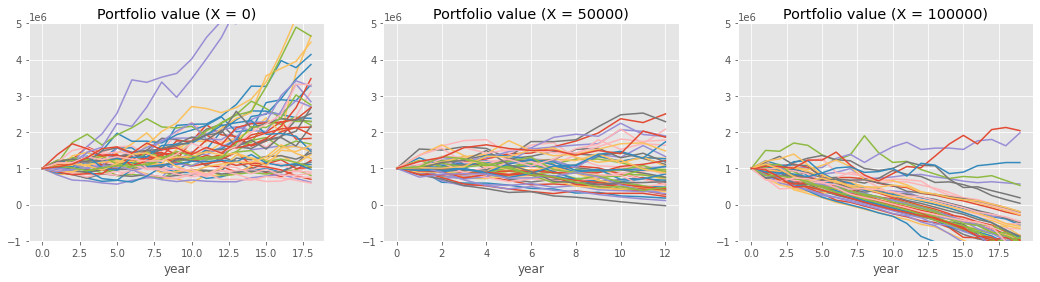

In [4]:
fig, axs = plt.subplots(1, 3, figsize = (18,4))
for i,x in enumerate([0,50000,100000]):
    total = sim_port(X = x, Y = 60, N_sim = 1000)[1]
    df = pd.DataFrame(total[:50].T)
    df.plot.line(ax = axs[i], legend = False, ylim = (-1000000,5000000))
    axs[i].set_xlabel('year')
    axs[i].set_title('Portfolio value (X = {0})'.format(x))

Now, let's simulate multiple times to see which number of simulation is optimal. Let's use X = 200000, Y = 60, and number of simulation in [100, 1000, 5000, 10000]. For each number of simulation, run 50 times to get average runtime and deviation.

[Text(0.5, 1.0, 'Avg runtime (sec)')]

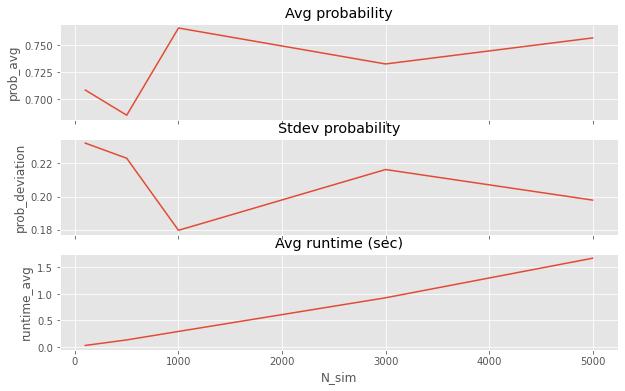

In [5]:
# N_sim_list = [100,500,1000,3000,5000]
# performance = np.zeros([len(N_sim_list), 4])

# for i,N in enumerate(N_sim_list):
    
#     prob_list, time_list = [], []
#     for k in range(50):
#         start_time = time.time()
#         prob_list.append(sim_port(X = 200000, Y = 60, N_sim = N)[0])
#         time_list.append(time.time() - start_time)
    
#     performance[i,:] = [N, np.mean(prob_list), np.std(prob_list), np.mean(time_list)]
    
# df_perf = pd.DataFrame(performance, columns = ['N_sim','prob_avg','prob_deviation','runtime_avg'])
# df_perf.to_csv('run_table', index = False)

df_perf = pd.read_csv('run_table')

fig, axs = plt.subplots(3, 1, figsize = (10,6))
sns.lineplot(data=df_perf , x="N_sim", y="prob_avg", ax = axs[0]).set(title = 'Avg probability', xlabel = None, xticklabels = [])
sns.lineplot(data=df_perf , x="N_sim", y="prob_deviation", ax = axs[1]).set(title = 'Stdev probability', xlabel = None, xticklabels = [])
sns.lineplot(data=df_perf , x="N_sim", y="runtime_avg", ax = axs[2]).set(title = 'Avg runtime (sec)')

We can see that average runtime increases linearly as we increase number of simulation. However, the average probability starts to converge at around 1,000 simulations where the deviation of probability is the lowest and starts to converge. Thus, I will use N_sim = 1,000 for data generation in the next step.

### Generate 10,000 samples

Generate 10,000 samples by using N_sim = 1,000. Choose X randomly between 10,000 and 100,000. The range of integer Y is between 50 and 65. I used the code below to run and save the results, then download it later for the next step.

In [6]:
# def gen_sample(N_obs):
    
#     X = np.random.uniform(10000, 100000, size = (N_obs,1))
#     Y = np.random.randint(50, 66, size = (N_obs,1))
#     prob = [sim_port(X = x, Y = y, N_sim = 1000)[0] for x,y in zip(X,Y)]
    
#     return [X,Y,prob]

# out = gen_sample(10000)
# df = pd.DataFrame({'x': [x[0] for x in out[0].tolist()], 
#                    'y': [x[0] for x in out[1].tolist()], 
#                    'p': [x for x in out[2]]})
# df.to_csv('gen_sample', index = False)

### Fit ML model

Before we fit the model, it is worth looking into actual data. I binned X into 10 quantiles to plot probability heatmap. Overall, we can clearly see that the probability of running out of money is high when yearly withdraw (X) is high or age (Y) is low (more years to withdraw money on average). That makes sense. I renamed the features X and Y to 'amt' and 'age' just to make sure we will not get confused with X and y when fitting model.

In [7]:
df = pd.read_csv('gen_sample')
df.columns = ['amt','age','p']
df.describe()

,amt,age,p
count,10000.000000,10000.000000,10000.000000
mean,54830.832171,57.453200,0.313156
std,25986.059735,4.628364,0.322084
min,10000.033750,50.000000,0.000000
25%,32669.013581,53.000000,0.007000
50%,54498.504631,57.000000,0.189000
75%,77360.664634,61.000000,0.601000
max,99995.575904,65.000000,0.970000


Text(0.5, 1.0, 'Average probability of running out of money')

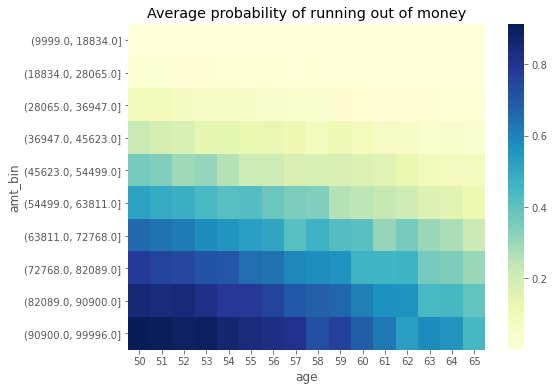

In [8]:
X = df[['amt','age']].values
y = df['p'].values

df['amt_bin'] = pd.qcut(df['amt'], q=10, precision=0)
df_avg = df.groupby(['amt_bin','age']).mean().reset_index().pivot(index = 'amt_bin', columns = 'age', values = 'p')

fig, ax = plt.subplots(1, 1, figsize = (8,6))
sns.heatmap(df_avg, cmap = 'YlGnBu')
ax.set_title('Average probability of running out of money')

Given only 2 numeric features in the data set (withdrawal amount and age) and a continuous target, I would use a simple model which does not require many features such as Regression Tree. To tune hyperparamters, I choose Hyperopt to optimize tuning in a predefined search space. It's core approach is TPE (Tree-structured Parzen Estimator) which uses Bayesian approach for optimization. The objective function is to minimize average MSE from cross validation. 

#### Regression Tree

I chose 4 hyperparameters, i.e., max_depth, max_features, min_samples_split and min_samples_leaf. All of them are defined in a search space with choices of values. 

    1) max_depth: [1,2,...,9]
    2) max_features: [1,2]
    3) min_samples_split: [100,101,102,...,999]
    4) min_samples_leaf: [100,101,102,...,999]

The model is evaluated by the average of MSE from 5-fold cross validation.

In [9]:
def hp_train_test(params):
    model = DecisionTreeRegressor(**params)
    return cross_val_score(model, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()

def f(params):
    mse = - hp_train_test(params)
    return {'loss': mse, 'status': STATUS_OK}

search_space = {
    'max_depth': hp.choice('max_depth', range(1,10)),
    'max_features': hp.choice('max_features', range(1,3)),
    'min_samples_split': hp.choice('min_samples_split', range(100,1000)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(100,1000))
}

trials = Trials()
best = fmin(f, search_space, algo = tpe.suggest, max_evals = 500, trials = trials)
print('best hyperparameters: ', best)

100%|██████████| 500/500 [01:03<00:00,  7.86trial/s, best loss: 0.021231135197207242]
best hyperparameters:  {'max_depth': 7, 'max_features': 1, 'min_samples_leaf': 0, 'min_samples_split': 22}


The above results show optimal index of hyperparameters from the test.

    1) max_depth = 8 (index 0 starts at 1)
    2) max_features = 2
    3) min_samples_split = 122
    4) min_samples_leaf = 100

The plots below show trials of parameters from the optimization. Darker dots mean values around that area were tried more often in the optimization. Vertical axis is average MSE which we try to minimize. We can see from max_depth plot that as max_depth goes higher, average MSE tends to decrease. However, its improvement is miniscule once the values are higher than 4. 

Similarly, when max_features is 2 (1.0 in plot), average MSE is often lower since the more features we have in the tree, the better the model would be (we only have 2 features and from heatmap, both of them show distinct patterns). 

For min_samples_split and min_samples_leaf, lower the values means lower MSEs. That totally makes sense because you will get more accurate results. In the search space, I chose a range between 100 and 999. Lowering lower bound will likely lead to lower MSEs, but the model might be overfitting when we predict out-of-sample, and we want to avoid that.

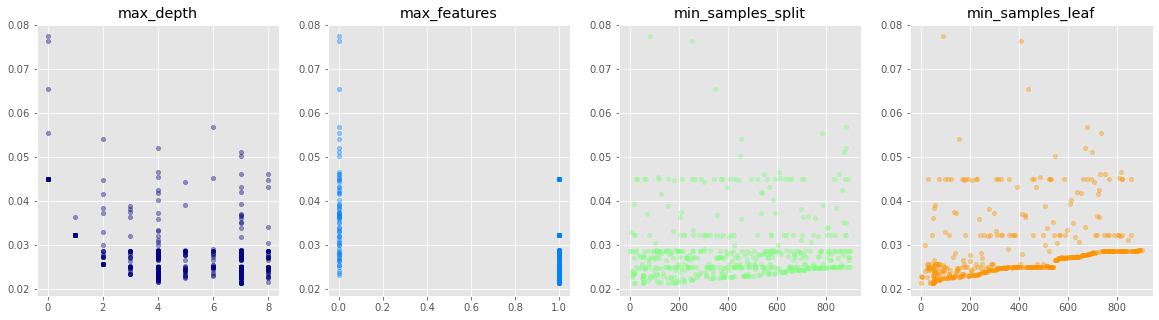

In [10]:
param_list = list(search_space.keys())

fig, axs = plt.subplots(1, len(param_list), figsize = (20,5))
cmap = plt.cm.jet
for i,v in enumerate(param_list):
    xs = np.array([t['misc']['vals'][v] for t in trials.trials])
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs,ys)))
    ys = np.array(ys)
    axs[i].scatter(xs, - ys, s = 20, alpha = 0.4, c = np.array(cmap(float(i)/len(param_list))).reshape(1,-1))
    axs[i].set_title(v)

We can also observe from the plot below, which shows index values of max_depth over 200 trials by order. The algorithm apparently tried max_depth most frequently at 5 (index 4) and the optimal value 8 (index 7).

Text(0, 0.5, 'max_depth')

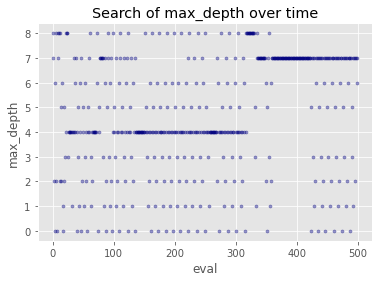

In [11]:
fig, ax = plt.subplots(1, 1)
xs = [t['tid'] for t in trials.trials]
ys = [t['misc']['vals']['max_depth'] for t in trials.trials]
ax.scatter(xs, ys, alpha = 0.4, s = 10, c = 'navy')
ax.set_title('Search of max_depth over time')
ax.set_xlabel('eval')
ax.set_ylabel('max_depth')

### Appendix

Another function to calculate probability of running out of money.

In [ ]:
def sim_port2(X, 
              Y, 
              N_sim = 100, 
              init = 1000000, 
              allocation = np.array([0.6,0.4]), 
              mu = np.array([0.06, 0.03]), 
              sigma = np.array([0.20, 0.03]), 
              rho = 0.2):
    
    # initial position
    init_pos = np.array([p*init for p in allocation])
    
    if Y>=50 and Y<=65:
        T = int(np.random.randint(70-Y, 90-Y, 1))
    else:
        raise ValueError('Input Y error!')
    
    N_step = int(T*252)
    t = np.linspace(Y, Y+T, N_step)
    dt = t[1] - t[0]
    
    # Cholesky decomposition
    L = np.array([1, 0, rho, np.sqrt(1-rho**2)]).reshape(2,-1)
    
    # an array to store portfolio value: first N_sim rows for stock, last N_sim rows for bond
    port_val = np.zeros([2 * N_sim, int(T+1)])
    port_val[:,0] = np.repeat(init_pos.reshape(2,-1), N_sim, axis = 0).flatten()
    
    # empty array to store daily total portfolio value for each year
    daily_total_val = np.zeros([N_sim, 252])
    daily_val = np.zeros([2 * N_sim, 252])
    
    # empty array used to update allocation after rebalancing
    total_val = np.zeros([N_sim, 1])
    
    # empty array to store default path
    default = np.zeros([N_sim, T])
    
    # drift and diffusion term in GBM
    drift = np.repeat(((mu - 0.5 * sigma**2) * dt).reshape(2,-1), N_sim * 252, axis = 0).reshape(2*N_sim,252)
    diff = (np.matmul(L, np.vstack([np.random.normal(0, sigma[0], N_sim * 252 * T), 
                                    np.random.normal(0, sigma[1], N_sim * 252 * T)]))
            * (np.sqrt(dt))).reshape(2 * N_sim * 252 * T,-1)
    
    # loop over every year
    for i in range(1, T+1):
        
        # use cumulative sum to get values every day
        diffusion = np.vstack([diff[(i-1) * N_sim * 252: i * N_sim * 252].reshape(N_sim,252).cumsum(1), 
                               diff[N_sim * 252 * T + (i-1) * N_sim * 252: N_sim * 252 * T + i * N_sim * 252].reshape(N_sim,-1).cumsum(1)])
        
        # keep daily total portfolio value to check for negative paths
        daily_val = (np.exp(drift + diffusion).T * port_val[:,i-1]).T
        daily_total_val[:,:] = daily_val[:N_sim] + daily_val[N_sim:]
        default[:,1] = [np.any([path<0]) for path in daily_total_val]
        
        # update portfolio value at the end of the year
        port_val[:,i] = (np.exp(drift + diffusion).T * port_val[:,i-1]).T[:,-1]
        
        # update balance after drawing out $X
        total_val[:,0] = port_val[:N_sim,i] + port_val[N_sim:,i] - X
        port_val[:N_sim,i] = total_val[:,0] * allocation[0]
        port_val[N_sim:,i] = total_val[:,0] * allocation[1]
    
    port_val_total = port_val[:N_sim] + port_val[N_sim:]
    p = np.mean([np.any([sim>0]) for sim in default])
    
    # return prob, total portfolio value yearly, stock value yearly and bond value yearly (after rebalancing)
    return p, port_val_total, port_val[:N_sim], port_val[N_sim:]

In [ ]:
start_time = time.time()
p, total, stock, bond = sim_port2(X = 40000, Y = 50, N_sim = 1000)

print('probability: ', p)
print('time taken: ', time.time() - start_time, ' seconds')